In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


19CSE305 - Machine Learning

# Pneumonia Detection and Classification From X-Ray Scans

## Team

1. Gomathi .R - CB.EN.U4CSE19017
2. Gowtham Vegi  -  CB.EN.U4CSE19018 
3. Harini  - CB.EN.U4CSE19023
4. Saipadmesh  - CB.EN.U4CSE19058 

Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#**IMPORTING LIBRARIES**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import math
import os
import glob
import tables
from tqdm.notebook import tqdm
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
from numpy import asarray

# for CNN
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#**DOWNLOADING DATASET FROM KAGGLE**

In [ ]:
! mkdir ~/.kaggle

! cp "/content/drive/MyDrive/SEMESTER 5/kaggle.json" ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:00<00:00, 32.9MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.7MB/s]


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! unzip /content/chest-xray-pneumonia.zip -d "/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumoni

In [ ]:
# image = Image.open('')
# data = asarray(image) #numpy.ndarray
# image2 = Image.fromarray(data) #PIL.Image.Image
# image2.save("filename.jpeg")

# OpenCV

Split according to normal and pneumonia images

In [3]:
DIR = "/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    print(path)
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("--"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("--"*20)

/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/train
/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/test
/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray/val
----------------------------------------
Total Pneumonia Images: 4273
Total Normal Images: 1583
----------------------------------------


In [4]:
labels = ["Normal",'Pneumonia ']
values = [len(all_normal), len(all_pneumonia)]
colors = ['green', 'pink']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Image Category Distribution",
                  titlefont={'size': 30},      
                  )
iplot(fig)

## Shuffling data

In [5]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
norm = all_normal[:50] 
pnem = all_pneumonia[:50]

In [6]:
def printing(norm, pnem, columns):
    fig=plt.figure(figsize=(15, 10))
    for k in range(1, columns+1):
        fig.add_subplot(2, columns, k)
        plt.imshow(norm[k])
        plt.title('Normal')
        plt.axis(False)
    for i in range(1, columns+1):
        fig.add_subplot(2, columns, k+i)
        plt.imshow(pnem[i])
        plt.title('Pnemonia')
        plt.axis(False)

## Basic Preprocessing

The images are resized to a standard size, and blurred to reduce noise.

Here we use **bilateral filtering** instead of **gaussian blur** because bilateral filtering preserves more edges, and hence, can make the edge detection algorithm more accurate.

In [7]:
'''
Resizes images, converts them to grayscale and applies gaussian blur to ensure uniform images with less noise are obtained 
'''
def basic_preprocessing(normal_list, pneumonia_list=[]):
  new_normal=[]
  new_pneumonia=[]
  for i in range(len(normal_list)):
    img = cv2.imread(normal_list[i])
    img = cv2.resize(img, (128,128)) # resized to ensure every image is scaled to the same size
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grayscale of the image
    #blurred = cv2.GaussianBlur(img,(1,1),0) 
    #img = cv2.addWeighted(img,1,blurred,0.6)
    #img = cv2.GaussianBlur(img,(1,1),0)
    img = cv2.bilateralFilter(img, 10, 10, 10)
    new_normal.append(img) 

  for i in range(len(pneumonia_list)):
    img = cv2.imread(pneumonia_list[i])
    img = cv2.resize(img, (128,128)) # resized to ensure every image is scaled to the same size
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # grayscale of the image
    #blurred = cv2.GaussianBlur(img,(1,1),0) 
    #img = cv2.addWeighted(img,1,blurred,0.6)
    #img = cv2.GaussianBlur(img,(1,1),0)
    img = cv2.bilateralFilter(img, 10, 10, 10)
    new_pneumonia.append(img) 
  
  return new_normal,new_pneumonia
  


## Canny edge detection

In [8]:
'''
detect edges using canny edge detection
'''
def edge_detect(norm, pnem=[]):
    edge_norm = []
    edge_pnem = []
    for i in range(len(norm)):
        edges = cv2.Canny(norm[i], 80, 100)
        edge_norm.append(edges)
    for i in range(len(pnem)):
        edges = cv2.Canny(pnem[i], 80, 100)
        edge_pnem.append(edges)
    return edge_norm,edge_pnem
    

In [9]:
'''
find pixel density using fourier's method
'''
def pixel_density(norm,pnem):
  dens_norm = []
  dens_pnem = []
  for i in range(len(norm)):
    f = np.fft.fft2(norm[i])
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    dens_norm.append(magnitude_spectrum)
  for i in range(len(pnem)):
    f = np.fft.fft2(pnem[i])
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    dens_pnem.append(magnitude_spectrum)
  return dens_norm, edge_norm  

## Preprocessing sample

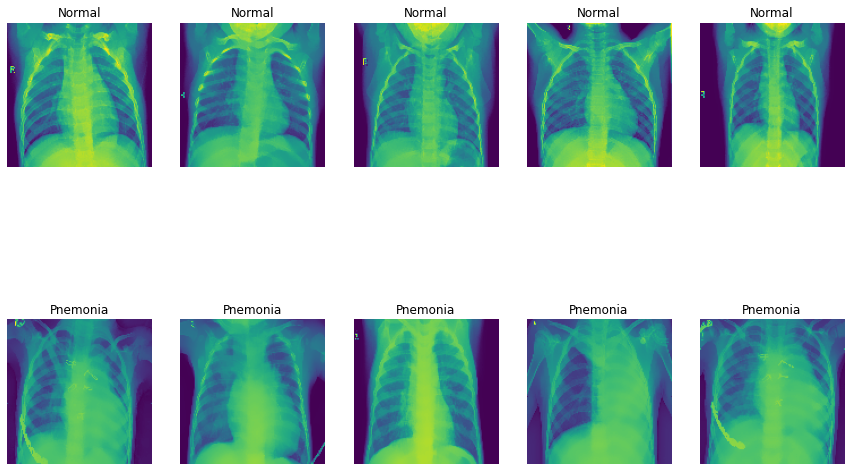

In [64]:
n,p=basic_preprocessing(norm, pnem)
# print("len n,p", len(n),len(p))
printing(n,p,5)

## Edge Detection sample 

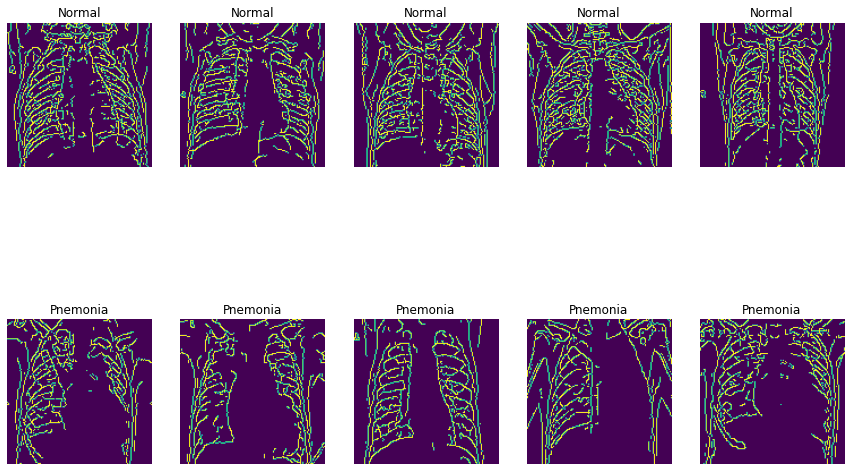

In [65]:
edge_norm, edge_pnem = edge_detect(n,p)
printing(edge_norm,edge_pnem,5)
# printing(n,p,5)

In [16]:
# from PIL import Image
# from numpy import asarray
# image = Image.open('')
# data = asarray(image) #numpy.ndarray
# image2 = Image.fromarray(data) #PIL.Image.Image
# '''
# '''
# DIR = "/content/drive/MyDrive/Colab Notebooks/ML/PROJECT/chest-xray-pneumonia/chest_xray"
# sets = ["train", "test", "val"]
# subsets = ["NORMAL","PNEUMONIA"]
# ls=[]
# #image = Image.open('/content/drive/MyDrive/Colab Notebooks/ML/PROJECT/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg')
# for cat in sets:
#     for cat2 in subsets:
#         path = os.path.join(DIR,cat )
#         path = glob.glob(os.path.join(path, cat2))
#         ls=[]
#         fname = "/content/drive/MyDrive/Colab Notebooks/ML/PROJECT/chest-xray-pneumonia/"+cat+cat2+".txt"
#         print(fname,"   --  APPENDING")
#         file = open(fname,"a")
#         for f in listdir(str(path[0])):
#             temppath = os.path.join(str(path[0]),f )
#             #print(temppath)
#             image = Image.open(temppath)
#             data = asarray(image) #numpy.ndarray
#             ls.append(data)
#         file.write(str(ls))
# f.close()

# Knn algorithm with preprocessed images

In [10]:
total_data = all_normal.copy()
total_labels = [0]*len(all_normal)
print(len(total_labels))
temp_labels1 = [1]*len(all_pneumonia)
total_labels=total_labels+(temp_labels1)
print(len(total_labels))
total_data=total_data+all_pneumonia.copy()
print(len(total_data))

1583
5856
5856


In [11]:
# shuffle the data
c = list(zip(total_data, total_labels))
random.shuffle(c)
total_data, total_labels = zip(*c)

In [12]:
# train, test split (40-20-20)
train_data = total_data[0:int(0.7*len(total_data))]
train_labels = total_labels[0:int(0.7*len(total_labels))]

val_data = total_data[int(0.7*len(total_data)):int(0.85*len(total_data))]
val_labels = total_labels[int(0.7*len(total_labels)):int(0.85*len(total_labels))]

test_data = total_data[int(0.85*len(total_data)):]
test_labels = total_labels[int(0.85*len(total_labels)):]


print('train size:',len(train_data))
print('val size:',len(val_data))
print('test size:',len(test_data))

train size: 4099
val size: 878
test size: 879


In [14]:
count=0
for t in train_labels:
  if(t == 1):
    count+=1
print("Pneumonia count:",count)
print("Normal count:",len(train_labels)-count)

Pneumonia count: 2965
Normal count: 1134


# no

In [55]:
'''
# without openCV preprocessing - Greyscale
img_dtype = tables.UInt8Atom()
hdf5_path = DIR+'/unprocessed_dataset.hdf5' 
hdf5_file = tables.open_file(hdf5_path, mode='w')

try:

  img = cv2.imread(val_data[0],0)
  img = cv2.resize(img, (128,128)) 
  img = cv2.equalizeHist(img)
  kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
  img = cv2.filter2D(src=img, ddepth = -1, kernel=kernel)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  val_storage = hdf5_file.create_earray(hdf5_file.root, 'val_img', obj=img[None])

  img = cv2.imread(train_data[0],0)
  img = cv2.resize(img, (128,128)) 
  img = cv2.equalizeHist(img)
  kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
  img = cv2.filter2D(src=img, ddepth = -1, kernel=kernel)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  train_storage = hdf5_file.create_earray(hdf5_file.root, 'train_img', obj=img[None])

  img = cv2.imread(test_data[0],0)
  img = cv2.resize(img, (128,128)) 
  img = cv2.equalizeHist(img)
  kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
  img = cv2.filter2D(src=img, ddepth = -1, kernel=kernel)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  test_storage = hdf5_file.create_earray(hdf5_file.root, 'test_img', obj=img[None])

  hdf5_file.create_array(hdf5_file.root, 'train_labels', train_labels)
  hdf5_file.create_array(hdf5_file.root, 'val_labels', val_labels)
  hdf5_file.create_array(hdf5_file.root, 'test_labels', test_labels)

  
  
  for i in range(1,len(val_data)):
    
    img = cv2.imread(val_data[i],0)
    img = cv2.resize(img, (128,128)) 
    img = cv2.equalizeHist(img)
    kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    img = cv2.filter2D(src=img, ddepth = -1, kernel=kernel)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    val_storage.append(img[None])
  
  print("Validation done")
  
  
  for i in range(1,len(train_data)):
    img = cv2.imread(train_data[i],0)
    img = cv2.resize(img, (128,128)) 
    img = cv2.equalizeHist(img)
    kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    img = cv2.filter2D(src=img, ddepth = -1, kernel=kernel)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    train_storage.append(img[None])
  
  print("Training data done")

  
  for i in range(1,len(test_data)):
    img = cv2.imread(test_data[i],0)
    img = cv2.resize(img, (128,128)) 
    img = cv2.equalizeHist(img)
    kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    img = cv2.filter2D(src=img, ddepth = -1, kernel=kernel)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    test_storage.append(img[None])
  
  print("Testing data done")
  
  
  print('HDF5 Done')
finally:
  print('In Finally')
  hdf5_file.close()
    
'''
print()
    

In [25]:
'''
DIR = "/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray"
hdf5_path = DIR+'/unprocessed_dataset.hdf5'
hdf5_file = tables.open_file(hdf5_path, mode='r')
train_data_preprocessed = np.array(hdf5_file.root.train_img)
train_label_preprocessed = np.array(hdf5_file.root.train_labels)

test_data_preprocessed = np.array(hdf5_file.root.test_img)
test_label_preprocessed = np.array(hdf5_file.root.test_labels)

val_data_preprocessed = np.array(hdf5_file.root.val_img)
val_label_preprocessed = np.array(hdf5_file.root.val_labels)

print('train data:',train_data_preprocessed.shape,' train_label',train_label_preprocessed.shape)
print('test_data:',test_data_preprocessed.shape,' test_label:',test_label_preprocessed.shape)
print('val_data:',val_data_preprocessed.shape,' val_label:',val_label_preprocessed.shape)
hdf5_file.close()
'''
print()

In [27]:
'''
# with openCV preprocessing - Greyscale
img_dtype = tables.UInt8Atom()
hdf5_path = DIR+'/dataset.hdf5' 
hdf5_file = tables.open_file(hdf5_path, mode='w')

try:

  n=basic_preprocessing([val_data[0]])[0]
  e=edge_detect(n)[0][0]
  e = np.expand_dims(e, axis=2)
  val_storage = hdf5_file.create_earray(hdf5_file.root, 'val_img', obj=e[None])

  n=basic_preprocessing([train_data[0]])[0]
  e=edge_detect(n)[0][0]
  e = np.expand_dims(e, axis=2)
  train_storage = hdf5_file.create_earray(hdf5_file.root, 'train_img', obj=e[None])

  n=basic_preprocessing([test_data[0]])[0]
  e=edge_detect(n)[0][0]
  e = np.expand_dims(e, axis=2)
  test_storage = hdf5_file.create_earray(hdf5_file.root, 'test_img', obj=e[None])

  hdf5_file.create_array(hdf5_file.root, 'train_labels', train_labels)
  hdf5_file.create_array(hdf5_file.root, 'val_labels', val_labels)
  hdf5_file.create_array(hdf5_file.root, 'test_labels', test_labels)

  # pre-process validation data and add to storage
  n=basic_preprocessing(val_data)[0]
  val_data_preprocessed = edge_detect(n)[0]
  
  for i in range(1,len(val_data_preprocessed)):
    #img = np.rollaxis(img, 2)
    #print(img[None].shape)
    img = val_data_preprocessed[i]
    img = np.expand_dims(img, axis=2)
    val_storage.append(img[None])
  
  print("Validation done")
  
  # pre-process training data and add to storage
  n=basic_preprocessing(train_data)[0]
  train_data_preprocessed = edge_detect(n)[0]
  for i in range(1,len(train_data_preprocessed)):
    img = train_data_preprocessed[i]
    img = np.expand_dims(img, axis=2)
    train_storage.append(img[None])
  
  print("Training data done")

  # pre-process test data and add to storage
  n=basic_preprocessing(test_data)[0]
  test_data_preprocessed = edge_detect(n)[0]
  for i in range(1,len(test_data_preprocessed)):
    img = test_data_preprocessed[i]
    img = np.expand_dims(img, axis=2)
    test_storage.append(img[None])
  
  print("Testing data done")
  
  
  print('HDF5 Done')
finally:
  print('In Finally')
  hdf5_file.close()
'''
print()
    

# Preprocessing

In [15]:
# with openCV preprocessing
img_dtype = tables.UInt8Atom()
hdf5_path = DIR+'/dataset.hdf5' 
hdf5_file = tables.open_file(hdf5_path, mode='w')

try:

  n=basic_preprocessing([val_data[0]])[0]
  e=edge_detect(n)[0][0]
  e = np.expand_dims(e, axis=2)
  val_storage = hdf5_file.create_earray(hdf5_file.root, 'val_img', obj=e[None])

  n=basic_preprocessing([train_data[0]])[0]
  e=edge_detect(n)[0][0]
  e = np.expand_dims(e, axis=2)
  train_storage = hdf5_file.create_earray(hdf5_file.root, 'train_img', obj=e[None])

  n=basic_preprocessing([test_data[0]])[0]
  e=edge_detect(n)[0][0]
  e = np.expand_dims(e, axis=2)
  test_storage = hdf5_file.create_earray(hdf5_file.root, 'test_img', obj=e[None])

  hdf5_file.create_array(hdf5_file.root, 'train_labels', train_labels)
  hdf5_file.create_array(hdf5_file.root, 'val_labels', val_labels)
  hdf5_file.create_array(hdf5_file.root, 'test_labels', test_labels)

  # pre-process validation data and add to storage
  n=basic_preprocessing(val_data)[0]
  val_data_preprocessed = edge_detect(n)[0]
  
  for i in range(1,len(val_data_preprocessed)):
    #img = np.rollaxis(img, 2)
    #print(img[None].shape)
    img = val_data_preprocessed[i]
    img = np.expand_dims(img, axis=2)
    val_storage.append(img[None])
  
  print("Validation done")
  
  # pre-process training data and add to storage
  n=basic_preprocessing(train_data)[0]
  train_data_preprocessed = edge_detect(n)[0]
  for i in range(1,len(train_data_preprocessed)):
    img = train_data_preprocessed[i]
    img = np.expand_dims(img, axis=2)
    train_storage.append(img[None])
  
  print("Training data done")

  # pre-process test data and add to storage
  n=basic_preprocessing(test_data)[0]
  test_data_preprocessed = edge_detect(n)[0]
  for i in range(1,len(test_data_preprocessed)):
    img = test_data_preprocessed[i]
    img = np.expand_dims(img, axis=2)
    test_storage.append(img[None])
  
  print("Testing data done")
  
  
  print('HDF5 Done')
finally:
  print('In Finally')
  hdf5_file.close()

Validation done
Training data done
Testing data done
HDF5 Done
In Finally


In [16]:
DIR = "/content/drive/MyDrive/SEMESTER 5/19CSE305 - MACHINE LEARNING/chest-xray-pneumonia/chest_xray"
hdf5_path = DIR+'/dataset.hdf5'
hdf5_file = tables.open_file(hdf5_path, mode='r')
train_data_preprocessed = np.array(hdf5_file.root.train_img)
train_label_preprocessed = np.array(hdf5_file.root.train_labels)

test_data_preprocessed = np.array(hdf5_file.root.test_img)
test_label_preprocessed = np.array(hdf5_file.root.test_labels)

val_data_preprocessed = np.array(hdf5_file.root.val_img)
val_label_preprocessed = np.array(hdf5_file.root.val_labels)

print('train data:',train_data_preprocessed.shape,' train_label',train_label_preprocessed.shape)
print('test_data:',test_data_preprocessed.shape,' test_label:',test_label_preprocessed.shape)
print('val_data:',val_data_preprocessed.shape,' val_label:',val_label_preprocessed.shape)
hdf5_file.close()


train data: (4099, 128, 128, 1)  train_label (4099,)
test_data: (879, 128, 128, 1)  test_label: (879,)
val_data: (878, 128, 128, 1)  val_label: (878,)


In [17]:
train_data = np.squeeze(train_data_preprocessed)
test_data = np.squeeze(test_data_preprocessed)

In [18]:
train_data = train_data.reshape(len(train_data),128*128)
train_data =train_data/255
test_data = test_data.reshape(len(test_data),128*128)
test_data =test_data/255

In [21]:
train_label = train_label_preprocessed
test_label = test_label_preprocessed

Random Forest

In [31]:
rf = RandomForestClassifier(criterion="entropy")
rf.fit(train_data, train_label)

RandomForestClassifier(criterion='entropy')

In [32]:
predicted_label = rf.predict(train_data)
accuracy_score(train_label, predicted_label)

1.0

In [33]:
predicted_label = rf.predict(test_data)
accuracy_score(test_label, predicted_label)

0.888509670079636

In [37]:
predicted_label = rf.predict(test_data)
cm =confusion_matrix(test_label,predicted_label)
cm

array([[167,  61],
       [ 37, 614]])

KNN


In [22]:
n = int (math.sqrt(len(train_data)) ) -1
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(train_data,train_label)

KNeighborsClassifier(n_neighbors=63)

In [23]:
predicted_label = knn.predict(train_data)
accuracy_score(train_label, predicted_label)

0.7233471578433764

In [24]:
predicted_label = knn.predict(test_data)
cm =confusion_matrix(test_label,predicted_label)
cm

array([[  0, 228],
       [  0, 651]])

In [35]:
#print(classification_report(test_label, predicted_label))

In [ ]:
0.7518907050500122

SVM

In [26]:
svm = SVC() 
svm.fit(train_data,train_label)

SVC()

In [27]:
predicted_label = svm.predict(train_data)
accuracy_score(train_label, predicted_label)

0.9951207611612588

In [28]:
predicted_label = svm.predict(test_data)
cm =confusion_matrix(test_label,predicted_label)
cm

array([[195,  33],
       [ 42, 609]])

In [29]:
print(classification_report(test_label, predicted_label))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       228
           1       0.95      0.94      0.94       651

    accuracy                           0.91       879
   macro avg       0.89      0.90      0.89       879
weighted avg       0.92      0.91      0.92       879



# Keras and OpenCV


In [100]:
batch_size = 50
nb_class = 2

In [27]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(train_label))
train_label = np_utils.to_categorical(train_label, num_classes)
test_label = np_utils.to_categorical(test_label, num_classes)
val_label = np_utils.to_categorical(val_label, num_classes)

# print shape of training set
print('num_classes:', num_classes)
print(train_label.shape, 'train samples')
print(test_label.shape, 'test samples')
print(val_label.shape, 'validation samples')


num_classes: 2
(4099, 2) train samples
(879, 2) test samples
(878, 2) validation samples


In [28]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(128,128,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='tanh'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [33]:

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(train_data, train_label, batch_size=None, epochs=20,
validation_data=(val_data, val_label),callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/20


ValueError: ignored

In [32]:
model.load_weights('model.weights.best.hdf5')

OSError: ignored

In [ ]:
score = model.evaluate(test_data, test_label, verbose=0)
print('Test accuracy:', score[1])


Test accuracy: 0.9328782558441162


In [ ]:
hdf5_file.close()

# Keras with pre-trained model

In [ ]:
train_dir =  DIR + '/train'
val_dir =  DIR + '/val'
test_dir =  DIR + '/test'

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 50

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)



In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [ ]:
EPOCHS = 20

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
105/105 [==============================] - 1325s 13s/step - loss: 0.2667 - accuracy: 0.9066 - auc: 0.9453 - val_loss: 0.9332 - val_accuracy: 0.6250 - val_auc: 0.9453
Epoch 2/20
105/105 [==============================] - 264s 3s/step - loss: 0.1151 - accuracy: 0.9519 - auc: 0.9894 - val_loss: 0.6520 - val_accuracy: 0.6875 - val_auc: 1.0000
Epoch 3/20
105/105 [==============================] - 267s 3s/step - loss: 0.0974 - accuracy: 0.9640 - auc: 0.9919 - val_loss: 0.1717 - val_accuracy: 0.8750 - val_auc: 0.9922
Epoch 4/20
105/105 [==============================] - 262s 2s/step - loss: 0.0890 - accuracy: 0.9657 - auc: 0.9934 - val_loss: 0.6205 - val_accuracy: 0.7500 - val_auc: 0.9141
Epoch 5/20
105/105 [==============================] - 266s 3s/step - loss: 0.0863 - accuracy: 0.9630 - auc: 0.9941 - val_loss: 0.2654 - val_accuracy: 0.9375 - val_auc: 0.9844
Epoch 6/20
105/105 [==============================] - 264s 2s/step - loss: 0.0894 - accuracy: 0.9674 - auc: 0.9933 - val_lo

In [ ]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

test_data.class_indices

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

NameError: ignored

<Figure size 432x432 with 0 Axes>

In [ ]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [ ]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [ ]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))